# Project 4b - Image Warping and Mosaicing

### Dependencies

In [1]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from utils import computeH, warpImage, warpPoints, align_and_blend_images, get_harris_corners, dist2

## Interest Point Detector

In [2]:
# Load images and points
image_left = plt.imread('../data/4a/img/IMG_8428.jpeg')
image_right = plt.imread('../data/4a/img/IMG_8429.jpeg')

# make panoramal left b&w
image_left_gray = np.mean(image_left, axis=2)
image_right_gray = np.mean(image_right, axis=2)

h_left, coords_left = get_harris_corners(image_left_gray)
h_right, coords_right = get_harris_corners(image_right_gray)

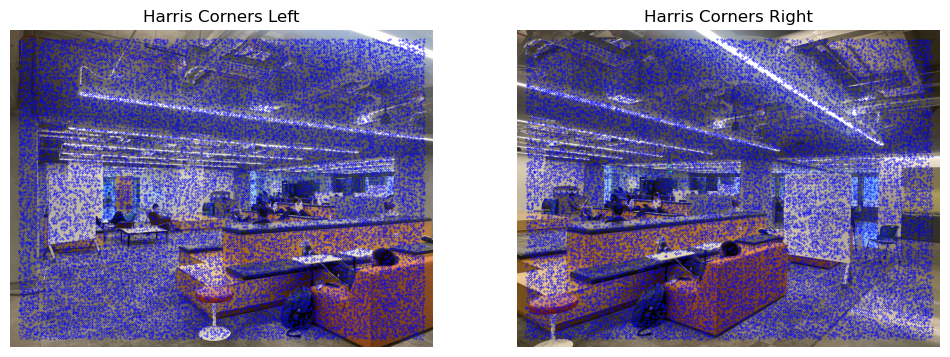

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display Harris corners for the left image
ax[0].imshow(image_left)
ax[0].scatter(coords_left[1], coords_left[0], c='b', s=0.1)
ax[0].set_title('Harris Corners Left')
ax[0].axis('off')

# Display Harris corners for the right image
ax[1].imshow(image_right)
ax[1].scatter(coords_right[1], coords_right[0], c='b', s=0.1)
ax[1].set_title('Harris Corners Right')
ax[1].axis('off')

plt.show()

## Adaptive Non-Maximal Suppression

In [4]:
def adaptive_non_maximal_suppression(corners: np.ndarray, h: np.ndarray, num_points: int = 500, c_robust: float = 0.9) -> np.ndarray:
    # Extract Harris strengths for each corner point
    scores = h[corners[0], corners[1]]
    
    # Calculate pairwise distances between all corners using dist2()
    dists = dist2(corners.T, corners.T)  # corners.T is of shape (n, 2)
    
    # Broadcast comparison: f(x_i) < c_robust * f(x_j)
    larger_mask = scores[:, np.newaxis] < (c_robust * scores[np.newaxis, :])
    
    # Mask the distances where the comparison holds and set the rest to infinity
    masked_dists = np.where(larger_mask, dists, np.inf)
    
    # Calculate the minimum radius for each point
    radii = np.min(masked_dists, axis=1)
    
    # Sort points by their radii in descending order
    sorted_indices = np.argsort(-radii)
    
    # Sort the original corners based on radii
    sorted_corners = corners[:, sorted_indices]
    
    return sorted_corners[:, :num_points]

# Apply Adaptive Non-Maximal Suppression to get top corners
suppressed_coords_left = adaptive_non_maximal_suppression(coords_left, h_left)
suppressed_coords_right = adaptive_non_maximal_suppression(coords_right, h_right)

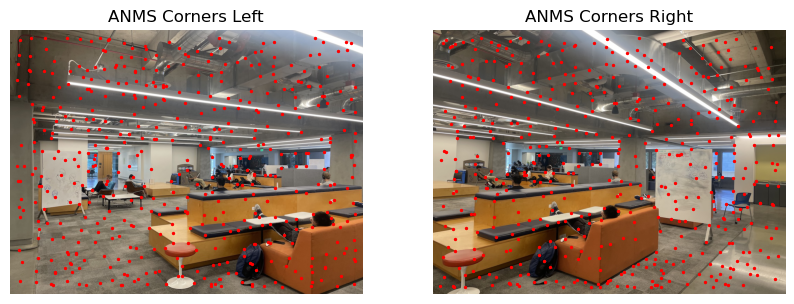

In [5]:
# Display ANMS corners
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Left image with ANMS corners
ax[0].imshow(image_left)
ax[0].scatter(suppressed_coords_left[1], suppressed_coords_left[0], c='r', s=2)
ax[0].set_title('ANMS Corners Left')
ax[0].axis('off')

# Right image with ANMS corners
ax[1].imshow(image_right)
ax[1].scatter(suppressed_coords_right[1], suppressed_coords_right[0], c='r', s=2)
ax[1].set_title('ANMS Corners Right')
ax[1].axis('off')

plt.show()

## Feature Descriptor Extraction

In [6]:
def extract_feature_descriptors(im: np.ndarray, coords: np.ndarray, patch_size: int = 8, window_size: int = 40, spacing: int = 5) -> np.ndarray:
    # Calculate half the window size for boundary checks
    half_window = window_size // 2

    # Check if the point is within the valid bounds of the image
    def is_within_bounds(y, x):
        return (half_window <= y < im.shape[0] - half_window and 
                half_window <= x < im.shape[1] - half_window)

    # Extract and normalize an 8x8 patch from a 40x40 window around the point (y, x) for a given channel
    def extract_patch(y, x, channel):
        # Extract the 40x40 window for the current channel
        window = im[y-half_window:y + half_window, x - half_window:x + half_window, channel]
        
        # Apply Gaussian blur to reduce aliasing
        window = gaussian_filter(window, sigma=1)

        # Sample an 8x8 patch from the window with specified spacing
        patch = window[::spacing, ::spacing][:patch_size, :patch_size]

        # Normalize the patch (bias/gain normalization)
        patch_mean = np.mean(patch)
        patch_std = np.std(patch)
        
        return (patch - patch_mean) / patch_std if patch_std > 0 else patch

    # Generate descriptors for each point in coords
    descriptors = [
        # Concatenate descriptors from all three channels to form a single vector
        np.concatenate([extract_patch(y, x, channel).flatten() for channel in range(3)])
        for y, x in coords.T if is_within_bounds(y, x)
    ]

    return np.array(descriptors)

descriptors_left = extract_feature_descriptors(image_left, suppressed_coords_left)
descriptors_right = extract_feature_descriptors(image_right, suppressed_coords_right)

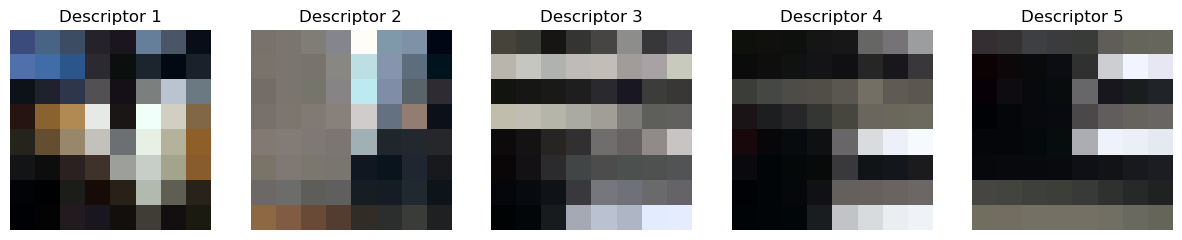

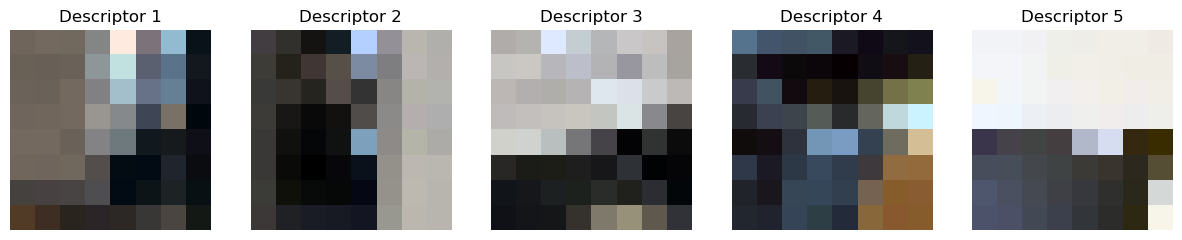

In [7]:
def visualize_descriptors(descriptors: np.ndarray, num_descriptors: int = 5, patch_size: int = 8) -> None:
    fig, axes = plt.subplots(1, num_descriptors, figsize=(15, 5))

    for i, ax in enumerate(axes[:num_descriptors]):
        descriptor = descriptors[i]
        
        # Reshape the descriptor into three 8x8 patches for R, G, B channels
        patches = [descriptor[j*patch_size*patch_size:(j+1)*patch_size*patch_size].reshape((patch_size, patch_size)) for j in range(3)]
        
        # Combine the patches into a single 8x8x3 RGB image
        patch_rgb = np.stack(patches, axis=-1)
        
        # Normalize the RGB image to [0, 1] for visualization
        patch_rgb = (patch_rgb - patch_rgb.min()) / (patch_rgb.max() - patch_rgb.min())
        
        # Display the RGB image
        ax.imshow(patch_rgb)
        ax.axis('off')
        ax.set_title(f'Descriptor {i+1}')
    
    plt.show()

visualize_descriptors(descriptors_left, num_descriptors=5)
visualize_descriptors(descriptors_right, num_descriptors=5)

## Feature Matching

In [8]:
def match_features(descriptors1: np.ndarray, descriptors2: np.ndarray, ratio_threshold: float = 0.8) -> List[Tuple[int, int]]:
    
    matches = []
    matched_in_second_image = set()  # Track points already matched in the second image
    
    for i, desc1 in enumerate(descriptors1):
        # Calculate distances to all descriptors in the second image
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        
        # Get the two nearest neighbors
        nearest_neighbor_idx, second_nearest_neighbor_idx = np.argsort(distances)[:2]
        
        # Apply Lowe's ratio test
        if distances[nearest_neighbor_idx] < ratio_threshold * distances[second_nearest_neighbor_idx]:
            # Ensure one-to-one matching
            if nearest_neighbor_idx not in matched_in_second_image:
                matches.append((i, nearest_neighbor_idx))
                matched_in_second_image.add(nearest_neighbor_idx)
    
    return matches

matches = match_features(descriptors_left, descriptors_right)

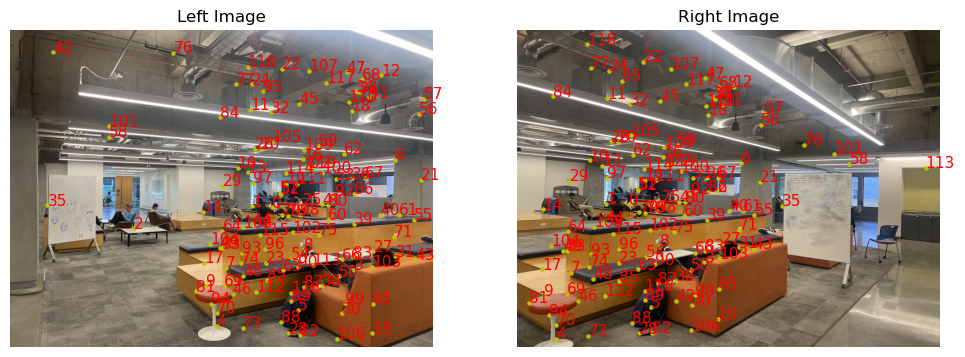

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')

ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

for idx, (i, j) in enumerate(matches):
    y1, x1 = suppressed_coords_left[:, i]
    y2, x2 = suppressed_coords_right[:, j]
    
    # plot the points on the image
    ax[0].scatter(x1, y1, c='y', s=5)
    ax[1].scatter(x2, y2, c='y', s=5)

    # Remove axis
    ax[0].axis('off')
    ax[1].axis('off')

    # number the points on both images
    ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
    ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

## 4-Point RANSAC

In [10]:
def warp_points_ransac(points, H):
    num_points = points.shape[0]
    homogeneous_points = np.hstack([points, np.ones((num_points, 1))])
    warped_points = H @ homogeneous_points.T
    warped_points /= warped_points[2, :]
    return warped_points[:2, :].T

def ransac(coords_1, coords_2, matches, num_iterations = 1000, threshold = 1):
    pts1 = []
    pts2 = []
    
    for idx, (i, j) in enumerate(matches):
        y1, x1 = coords_1[:, i]
        y2, x2 = coords_2[:, j]
        pts1.append([x1, y1])
        pts2.append([x2, y2])

    pts1 = np.array(pts1)
    pts2 = np.array(pts2)

    max_inliers = 0
    best_inliers = []

    for _ in range(num_iterations):
        # Randomly select 4 points
        random_indices = np.random.choice(len(matches), 4, replace=False)

        selected_pts1 = pts1[random_indices]
        selected_pts2 = pts2[random_indices]
        
        # Compute the homography using the selected points
        H_temp = computeH(selected_pts1, selected_pts2)
        
        inliers = []
        for idx in range(len(pts1)):
            pt1 = pts1[idx]
            pt2 = pts2[idx]

            warped_pt1 = warp_points_ransac(np.array([pt1]), H_temp)[0]
            dist = np.linalg.norm(warped_pt1 - pt2)

            if dist < threshold:
                inliers.append(idx)

        # Update the best set of inliers
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = inliers

    if max_inliers < 4:
        raise ValueError("Not enough inliers to compute a homography.")

    final_pts1 = pts1[best_inliers]
    final_pts2 = pts2[best_inliers]

    # Compute the final homography using all the inliers
    final_H = computeH(final_pts1, final_pts2)

    return final_H, best_inliers, final_pts1, final_pts2


final_H, best_inliers, best_im1_pts, best_im2_pts = ransac(suppressed_coords_left, suppressed_coords_right, matches)

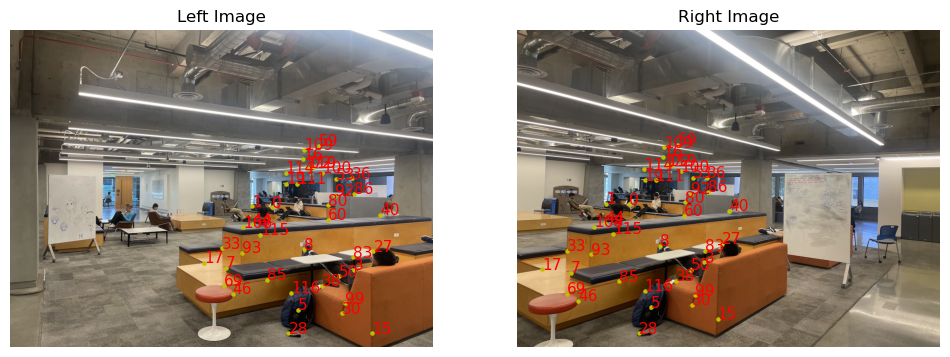

In [11]:
fix, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the left image
ax[0].imshow(image_left, cmap='gray')
ax[0].set_title('Left Image')

# Display the right image
ax[1].imshow(image_right, cmap='gray')
ax[1].set_title('Right Image')

# Loop through matches and process inliers
for idx, (i, j) in enumerate(matches):
    if idx in best_inliers:
        y1, x1 = suppressed_coords_left[:, i]
        y2, x2 = suppressed_coords_right[:, j]
        
        ax[0].axis('off')
        ax[0].scatter(x1, y1, c='y', s=5)
        ax[0].text(x1, y1, str(idx), fontsize=11, color='r')
        
        ax[1].axis('off')
        ax[1].scatter(x2, y2, c='y', s=5)
        ax[1].text(x2, y2, str(idx), fontsize=11, color='r')

plt.show()

In [12]:
# Warp the image
image_left_warped, min_x, min_y = warpImage(image_left, final_H)

# Warp the points
warped_points = warpPoints(best_im1_pts, final_H, min_x, min_y)

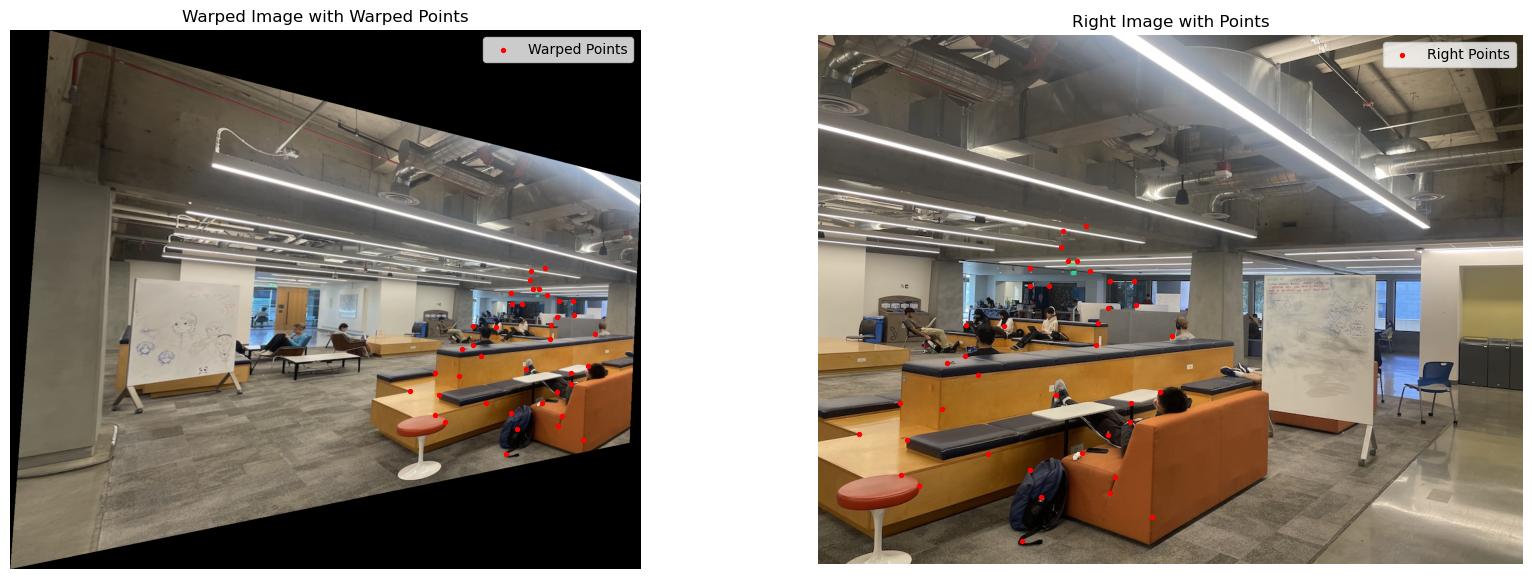

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

# Display the warped image on the left
ax[0].imshow(image_left_warped, cmap='gray')
ax[0].scatter(warped_points[:, 0], warped_points[:, 1], c='r', s=8, label='Warped Points')
ax[0].legend()
ax[0].set_title('Warped Image with Warped Points')
ax[0].axis('off')

# Display the right image on the right
ax[1].imshow(image_right, cmap='gray')
ax[1].scatter(best_im2_pts[:, 0], best_im2_pts[:, 1], c='r', s=8, label='Right Points')
ax[1].legend()
ax[1].set_title('Right Image with Points')
ax[1].axis('off')

plt.show()

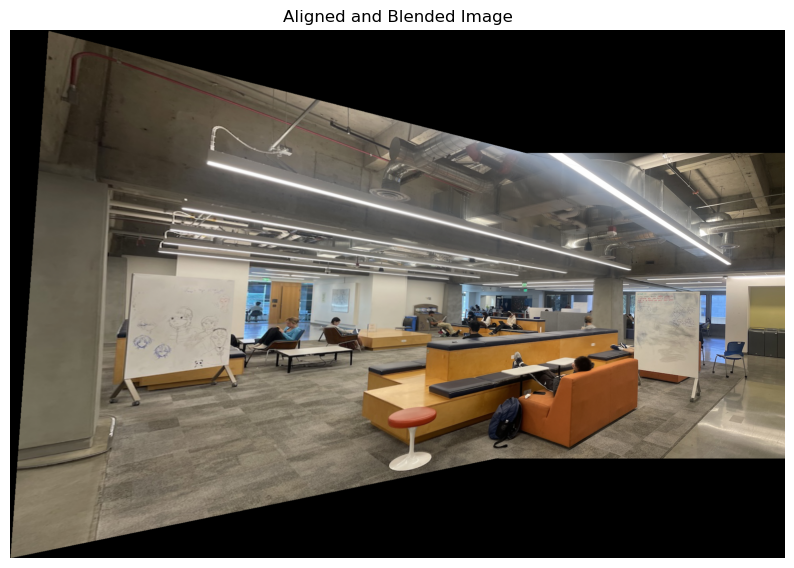

In [14]:
# Align and blend the images
result_image = align_and_blend_images(image_left_warped, image_right, warped_points, best_im2_pts)

# Display the result
fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(result_image)
ax.set_title('Aligned and Blended Image')
ax.axis('off')

plt.show()